In [1]:
# This notebook looks at a motif-based spectral embeddings for a transportation
# reachability network, whose structure was downloaded from
#     http://www.psi.toronto.edu/index.php?q=affinity%20propagation.                                                                                        
# We have agumented this dataset with the metropolitan and latitude/longitude
# of the cities (nodes in the network).  The notebook visualizes the
# motif-based embedding for the "2-hop path" motif and the standard edge-based
# embedding.  It also computes the correlation between the primary spectral
# coordinates and metropolitan population as well as the correlation between
# the secondary spectral coordinates and longitude.

In [2]:
# Set up the packages and data.
# WARNING: This may take several minutes if the packages have not been
#          downloaded before!
include("higher_order_packages.jl")
using MatrixNetworks
using MAT
using PyPlot

data = matread("data/reachability.mat");
A = spones(data["A"]);
B = min(A, A');

In [3]:
# Get embeddings, following algorithm of Ng et al., 2002.
function spectral_embedding(W::SparseMatrixCSC{Float64,Int64}, nev::Int64)
    d = sqrt(vec(sum(W,1)));
    n = length(d);
    ai,aj,av = findnz(W);
    Ln = sparse(ai, aj, -av./((d[ai].*d[aj])), n, n);
    Ln = Ln + 2 * speye(n);
    (lams, V, _) = MatrixNetworks._symeigs_smallest_arpack(Ln,nev,1e-12,300,d);
    s = vec(1 ./ sqrt(sum(V.^2,2)));
    return scale(s, V);
end
           
W = B * B;  # 2-hop path weighted matrix
T_motif = spectral_embedding(W, 3);
T_edge = spectral_embedding(max(A, A'), 3);
                                
# Adjust sign of coordinates to match the figure in the main text                                                                                           
labels = data["labels"];
labelind(s) = find(labels .== s)[1];
if T_motif[labelind("New York, NY"), 2] < 0
    T_motif[:, 2] = -T_motif[:, 2];
end
if T_motif[labelind("Monterey, CA"), 3] < 0
    T_motif[:, 3] = -T_motif[:, 3];
end
if T_edge[labelind("Atlantic City, NJ"), 2] < 0
    T_edge[:, 2] = -T_edge[:, 2];
end
if T_edge[labelind("Monterey, CA"), 3] < 0
    T_edge[:, 3] = -T_edge[:, 3];
end

456-element Array{Float64,1}:
 -0.827474 
 -0.0303263
  0.0748715
  0.36087  
  0.749139 
 -0.0764572
 -0.777485 
  0.149959 
 -0.0402147
 -0.405412 
  0.745644 
 -0.184855 
 -0.30006  
  ⋮        
  0.229231 
 -0.165419 
 -0.804042 
 -0.128883 
  0.770037 
 -0.111226 
 -0.862012 
 -0.697944 
  0.776413 
  0.334317 
 -0.875165 
  0.549122 

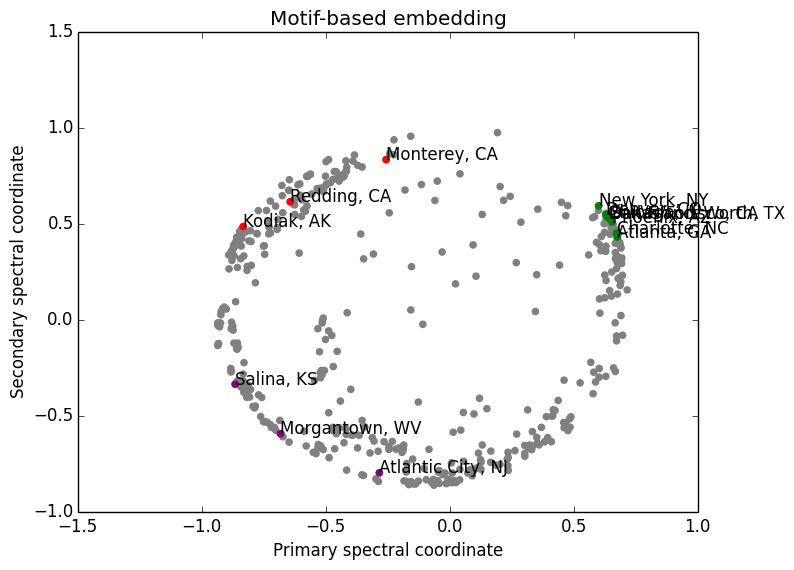

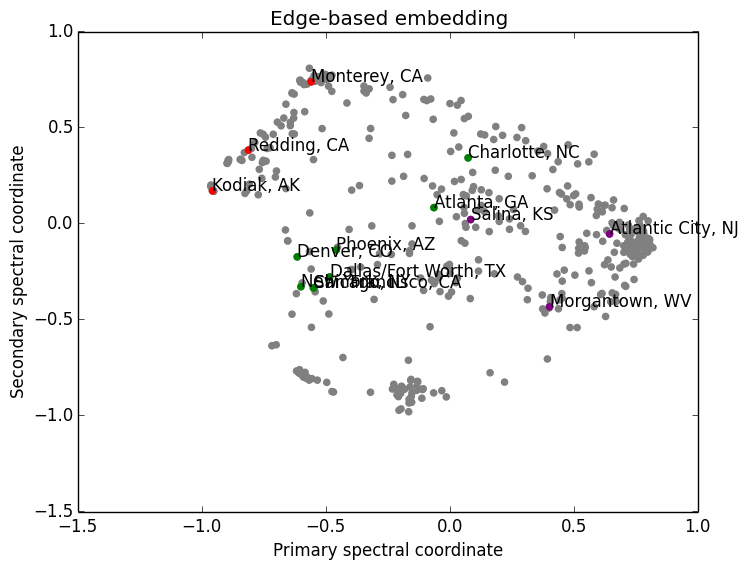

In [4]:
# Draw the embeddings

nonhubs_west = [labelind("Monterey, CA"),
                labelind("Redding, CA"),
                labelind("Kodiak, AK")]
nonhubs_east = [labelind("Salina, KS"),
                labelind("Morgantown, WV"),
                labelind("Atlantic City, NJ")]
hubs         = [labelind("New York, NY"),
                labelind("Denver, CO"),
                labelind("Chicago, IL"),
                labelind("Dallas/Fort Worth, TX"),
                labelind("San Francisco, CA"),
                labelind("Phoenix, AZ"),
                labelind("Charlotte, NC"),
                labelind("Atlanta, GA")]

function draw_embedding(T::Array{Float64,2}, titlestr::AbstractString)
    fig = figure(titlestr)
    scatter(T[:,2],            T[:,3],            color="grey")
    scatter(T[hubs,2],         T[hubs,3],         color="green")
    scatter(T[nonhubs_east,2], T[nonhubs_east,3], color="purple")
    scatter(T[nonhubs_west,2], T[nonhubs_west,3], color="red")
    for ind in [nonhubs_west; nonhubs_east; hubs]
        text(T[ind, 2], T[ind, 3], labels[ind])
    end
    xlabel("Primary spectral coordinate")
    ylabel("Secondary spectral coordinate")
    title(titlestr)
end

draw_embedding(T_motif, "Motif-based embedding");
draw_embedding(T_edge, "Edge-based embedding");

In [5]:
# Compute correlations                                                                                                                                      

# Correlation between primary spectral coordinate and metropolitan population                                                                               
@show cor([T_motif[:,2] data["populations"]]);
@show cor([T_edge[:,2] data["populations"]]);
# Correlation between secondary spectral coordinate and longitude                                                                                           
@show cor([T_motif[:,3] data["longitude"]]);
@show cor([T_edge[:,3] data["longitude"]]);

cor([T_motif[:,2] data["populations"]]) = [1.0 0.4346993560354394
 0.4346993560354394 1.0]
cor([T_edge[:,2] data["populations"]]) = [1.0 -0.10883939295855402
 -0.10883939295855402 1.0]
cor([T_motif[:,3] data["longitude"]]) = [1.0 -0.5884240200957398
 -0.5884240200957398 1.0]
cor([T_edge[:,3] data["longitude"]]) = [1.0 -0.39338526837160903
 -0.39338526837160903 1.0]


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':
